# making / fixing stuff

In [1]:
import sys
sys.path.append("/home/lauro/code/msc-thesis/svgd")

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
from jax.experimental import optimizers

import matplotlib.pyplot as plt
import numpy as onp
from tqdm import tqdm
import time
from functools import partial

import utils
import metrics
import plot
from svgd import SVGD
import svgd
import stein
import kernels
import train

rkey = random.PRNGKey(0)

from jax.config import config; config.update("jax_log_compiles", 1)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# New class

In [2]:
# config
kernel = kernels.ard
target = metrics.Gaussian(0, 10) # target dist
n = 500 # nr particles

lr_svgd = 1
lr_ksd = 1e-2

n_svgd_steps = 300
ksd_steps_per_svgd_step = 1


In [3]:
opt_svgd = train.Optimizer(*optimizers.sgd(step_size=lr_svgd))
opt_ksd  = train.Optimizer(*optimizers.momentum(step_size=lr_ksd, mass=0.9))

In [4]:
s = train.SVGD(target, n, kernel, lr_svgd, opt_svgd)

In [5]:
params, log = s.train_kernel(rkey, n_svgd_steps, ksd_steps_per_svgd_step, lr_ksd, opt_ksd)

JIT COMPILING init_svgd...
...done compiling init_svgd after 0.011297464370727539 seconds.


JIT COMPILING init_kernel...
...done compiling init_kernel after 0.02415919303894043 seconds.
JIT COMPILING init...
...done compiling init after 4.3392181396484375e-05 seconds.
JIT COMPILING init...
...done compiling init after 0.00028777122497558594 seconds.
JIT COMPILING get_params...
...done compiling get_params after 1.0728836059570312e-05 seconds.
JIT COMPILING get_params...
...done compiling get_params after 9.298324584960938e-06 seconds.
JIT COMPILING ksd_squared...


...done compiling ksd_squared after 0.7642364501953125 seconds.


JIT COMPILING update...
...done compiling update after 0.0008628368377685547 seconds.
JIT COMPILING phistar...
...done compiling phistar after 0.03858637809753418 seconds.


JIT COMPILING update...
...done compiling update after 0.0007476806640625 seconds.


In [6]:
params

DeviceArray(-0.30180895, dtype=float32)

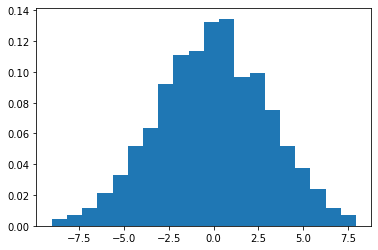

In [7]:
_ = plt.hist(np.squeeze(log["particles"][-1]), density=True, bins=20)

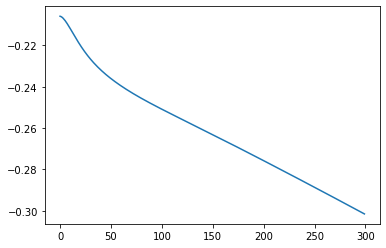

In [8]:
_ = plt.plot(log["kernel_param"])

In [9]:
sample = s.sample(rkey, params, n_svgd_steps)

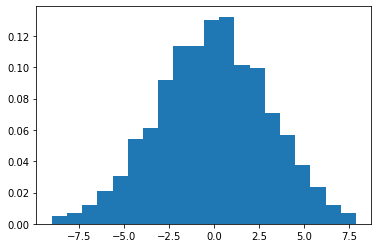

In [10]:
_ = plt.hist(np.squeeze(sample), density=True, bins=20)

In [11]:
alskdfj

NameError: name 'alskdfj' is not defined

# Using optimizers

In [ ]:
from jax.experimental import optimizers
from stein import ksd_squared

## SVGD and  KSD update

In [ ]:
n = 100
dist = metrics.Gaussian(0, 1)

In [ ]:
def init_svgd(key, particle_shape):
    return random.normal(key, particle_shape) * 2 - 3

def apply_svgd():
    pass

@partial(jit, static_argnums=1)
def phistar(xs, logp, kernel_params):
    return svgd.phistar(xs, logp, kernels.ard(kernel_params), None)

@jit
def apply_ksd(kernel_params, particles):
    return ksd_squared(particles, dist.logpdf, kernels.ard(kernel_params))

@jit
def init_ksd(key, particle_dim):
    return random.normal(key)

# Initialize particles and kernel parameters
particles0 = init_svgd(rkey, (n, 1))
kernel_params0 = init_ksd(rkey, 1)

# initialize optimizer states # TODO make optimizers individual, else uodates etc dont work
opt_init_svgd, opt_update_svgd, get_params_svgd = optimizers.sgd(step_size=1)
opt_state_svgd = opt_init_svgd(particles0) # now opt has stored particles in its state

opt_init_ksd, opt_update_ksd, get_params_ksd = optimizers.momentum(step_size=0, mass=0.9)
opt_state_ksd  = opt_init_ksd(kernel_params0) # now opt has stored params in its state

In [ ]:
dict(hi=1)

In [ ]:
n_iter = 100
hs = []
ps = []

for i in range(n_iter):
    # log
    hs.append(get_params_ksd(opt_state_ksd))
    ps.append(get_params_svgd(opt_state_svgd))
    
    particles     = get_params_svgd(opt_state_svgd)
    kernel_params = get_params_ksd(opt_state_ksd)
    
    # update kernel_params:
    gk = grad(apply_ksd)(kernel_params, particles)
    opt_state_ksd = opt_update_ksd(i, gk, opt_state_ksd)

    # update particles:
    gp = -phistar(particles, dist.logpdf, kernel_params)
    opt_state_svgd = opt_update_svgd(i, gp, opt_state_svgd)

In [ ]:
ps = [p[:, 0] for p in ps]

In [ ]:
_ =plt.hist(ps[-1])

In [ ]:
_ = plt.plot(hs)

In [ ]:
for i in range(n_iter):
    # log
    ps.append(get_params_svgd(opt_state_svgd))
    
    # update particles:
    gp = -phistar(particles, dist.logpdf, kernel_params)
    x = x + phistar(x, dist.log)

### animate

In [ ]:
%matplotlib widget
from matplotlib.animation import FuncAnimation

In [ ]:
# def update(frame):
#     i, particles = frame
#     if i % 10:
#         ax.clear()
#         ax.hist(particles, density=True, bins=30)
#     ax.set_title(f"Particles at iteration {i}")
#     return ax

# frames = enumerate(ps)
# fig, ax = plt.subplots()
# anim = FuncAnimation(fig, update, frames=frames)

# anim.event_source.stop() # pause
# anim.event_source.start() # unpause
# plt.show()

# Phistar

In [ ]:
def phistar(xs, logp, logh):
    def f(x, y):
        """evaluated inside the expectation"""
        kx = lambda y: kernels.ard(x, y, logh)
        return stein.stein_operator(kx, y, logp, transposed=False)
    
    fv  = vmap(f,  (None, 0))
    fvv = vmap(fv, (0, None))
    phi_matrix = fvv(xs, xs)
    
    n = xs.shape[0]
    trace_indices = [list(range(n))]*2
    phi_matrix = index_update(phi_matrix, trace_indices, 0)
    
    return np.mean(phi_matrix, axis=1)
#     return phi_matrix
phistar = jit(phistar, static_argnums=1)

In [ ]:
h = 1**2
n = 5
dist = metrics.Gaussian(0,1)
xs = dist.sample((n, 1))
print("phistar without diagonal", stein.phistar(xs, dist.logpdf, np.log(h)))
print("current with diagonal:", svgd.phistar(xs, dist.logpdf, np.log(h)))

# New KSD

Write KSD squared as
$$\text{KSD}(q \ \Vert \ p) = E_{Z, Z'}[g_p(Z, Z')]$$
where $Z$ and $Z'$ are independently distributed as $q$, and $g$ is defined as

$$\begin{aligned}
g_{p}(x, y):=& \nabla \log p(x)^{\top} \nabla \log p(y) k(x, y) \\
&+\nabla \log p(y)^{\top} \nabla_{x} k(x, y) \\
&+\nabla \log p(x)^{\top} \nabla_{y} k(x, y) \\
&+\left\langle\nabla_{x} k(x, \cdot), \nabla_{y} k(\cdot, y)\right\rangle_{\mathcal{F}^{d}}
\end{aligned}$$

The last term can also be written as
$$\sum_{i=1}^{d} \frac{\partial k(x, y)}{\partial x_{i} \partial y_{i}}.$$

Note that $g$ is equal to
$$g_p(x, y) = \mathcal A_p^T \mathcal A^{(y)}_p k(x, y).$$

In [ ]:
# code moved to stein.py

time:

In [ ]:
hgrid = np.logspace(-1, 3, num=100)
h = 1.5
dist = metrics.Gaussian(0,1)
x = dist.sample((100,1))
logp = dist.logpdf

In [ ]:
%timeit np.array([metrics.ksd_squared(x, logp, np.log(h)) for h in hgrid]).block_until_ready

In [ ]:
%timeit np.array(  [stein.ksd_squared(x, logp, np.log(h)) for h in hgrid]).block_until_ready

In [ ]:
stein.ksd_squared(x, logp, np.log(h))

In [ ]:
metrics.ksd_squared(x, logp, np.log(h))

In [ ]:
slkfj

# making new ard

In [ ]:
x = np.array([1,2])
A = np.array([[1, 2], [3, 4]])

In [ ]:
np.matmul(A, x)

In [ ]:
kernels.ard_m(x, y, A)

In [ ]:
kernels.ard_m(1, 2, 3)

# fixing phistar

In [ ]:
dist = metrics.Gaussian(0, 1)

In [ ]:
z = np.array([1.])
x = np.array([2.])
mu = 1
n = 100

def k(y):
    return np.exp(-1/2 * (y - z)**2)


print(stein.stein_operator(k, x, dist.logpdf))
print(k(x) * (z - 2*x))

In [ ]:
def phis(x):
    return - 1 / np.sqrt(2) * mu * np.exp(- 1/4 * (z - mu)**2)

In [ ]:
xs = dist.sample(shape=(n, 1)) + mu

print(svgd.phistar_i(z, xs, dist.logpdf, 1))
print(svgd._phistar_i(z, xs, dist.logpdf, 1))
print(phis(z))

In [ ]:
salkdfj

# still fixing `stein.stein`

In [ ]:
dist = metrics.Gaussian(0, 1)

In [ ]:
def fun(x):
    return np.exp(-x**2)

n = 100
steins = []
mugrid = np.linspace(-6, 6, num=50)

for mean in mugrid:
    sam = dist.sample(shape=(n, 1)) + mean
    steins.append(stein.stein(fun, sam, dist.logpdf))

In [ ]:
plt.plot(mugrid, steins)

Meanwhile, we know that for $f(x) = e^{-x^2}$ and $q = \mathcal N(\mu, 1)$,

$$
E_{x \sim q}[ \mathcal A_p [f] (x)] = - \frac{\mu}{\sqrt 3} \cdot e^{- \mu^2 / 3}
$$


In [ ]:
def stein_true(mu):
    return mu / np.sqrt(3) * np.exp(- mu**2 / 3)

In [ ]:
n = 100
tsteins = []
for mean in mugrid:
    tsteins.append(stein_true(mean))

In [ ]:
plt.plot(mugrid, tsteins)

In [ ]:
n = 100
steins = []
sigmagrid = np.linspace(-6, 6, num=50)

for sigma in sigmagrid:
    sam = dist.sample(shape=(n, 1)) * sigma
    steins.append(stein.stein(fun, sam, dist.logpdf))

This is supposed to be constant = 0. Checks out.

In [ ]:
plt.plot(sigmagrid, steins, "r.")

# fix `stein.stein`

In [ ]:
dist = metrics.Gaussian(0,1)
ngrid = np.arange(10, 1500, 50)

def fun(x):
    return np.exp(-x**2)

steins = []
for n in tqdm(ngrid):
    xs = dist.sample(shape=(n,1))
    steins.append(stein.stein(fun, xs, dist.logpdf))

In [ ]:
steins = np.array(steins)

In [ ]:
np.argmin(steins)

In [ ]:
plt.plot(ngrid, -steins, ".")
# plt.yscale("log")

# `phistar_i`

In [ ]:
asdjfh

In [ ]:
n = 200

dist = metrics.Gaussian([0, 0], [1, 1])
logp = dist.logpdf
bandwidth = 1

In [ ]:
ngrid = np.arange(10, 1000, 30)
phis = []
x = random.normal(rkey, shape=(2,))
for n in tqdm(ngrid):
    rkey = random.split(rkey)[0]
    xs = random.normal(rkey, shape=(n,2))
    phis.append(svgd._phistar_i(x, xs, logp, bandwidth))

In [ ]:
phis = np.array(phis)

In [ ]:
plt.plot(ngrid, np.abs(phis), ".")
# plt.yscale("log")

In [ ]:
svgd._phistar_i(xi, xs, logp, bandwidth) * n

In [ ]:
dist = metrics.Gaussian([1, 2], [1, 2])
logp = dist.logpdf
bandwidth = 1.

In [ ]:
n = 20

In [ ]:
sample = dist.sample(shape=(n,))
sample.shape

In [ ]:
svgd.phistar_i(x, sample, logp, bandwidth)

In [ ]:
svgd._phistar_i(x, sample, logp, bandwidth)

# test both ksds

In [ ]:
dist = metrics.Gaussian([1, 2], [1, 2])
logp = dist.logpdf
bandwidth = 1.

In [ ]:
n = 27

In [ ]:
sample = dist.sample(shape=(n,))
sample.shape

In [ ]:
metrics.ksd(sample, logp, bandwidth)

In [ ]:
metrics._ksd(sample, logp, bandwidth)

In [ ]:
metrics._ksd(sample, logp, bandwidth) * n

In [ ]:
sfjskjaf

# KSD thing

### short range

In [ ]:
dist = metrics.Gaussian(0, 1)
ngrid = np.arange(2, 100, 3)
ksds = []
mses = []
for n in tqdm(ngrid):
    x = dist.sample(shape=(n,))
    ksds.append(metrics._ksd(x, dist.logpdf, 1))
    mses.append(np.mean(x**2 - dist.expectations[1])**2)

In [ ]:
plt.plot(ngrid, ksds, "r.")
plt.yscale("log")

In [ ]:
plt.plot(ngrid, mses, ".")
plt.yscale("log")

### long range

In [ ]:
dist = metrics.Gaussian(0, 1)
ngrid = np.arange(5, 5000, 100)
ksds = []
mses = []
for n in tqdm(ngrid):
    x = dist.sample(shape=(n,))
    ksds.append(metrics._ksd(x, dist.logpdf, 1))
    mses.append(np.mean(x**2 - dist.expectations[1])**2)

In [ ]:
plt.plot(ngrid, ksds, "r.")
plt.yscale("log")

In [ ]:
plt.plot(ngrid, mses, ".")
plt.yscale("log")

## other samples

In [ ]:
rkey = random.split(rkey)[0]
s = random.normal(rkey, shape=(100, 1))

In [ ]:
metrics.ksd(s * 2, dist.logpdf, 1)

# other stuff

In [ ]:
n = 10
dist13 = metrics.GaussianMixture([-2, 2], [7, 7], [1/3, 2/3])
dist13.compute_metrics_for_sample(10)



s = dist13.sample(shape=(n,1))
# s = s[:, np.newaxis]

In [ ]:
dist14 = metrics.Gaussian(0, 1)
dist14.compute_metrics_for_sample(10)

In [ ]:
dist13.compute_metrics_for_sample(10)

In [ ]:
dist13.expectations

In [ ]:
dist13.compute_metrics(s) # throws ValueError

In [ ]:
s.reshape((n, 1))

In [ ]:
x = s
logp = dist13.logpdf
bandwidth = 1.

i = 0
j = 5
xi = x[i]
xj = x[j]


In [ ]:
def phistar_j(x, y, logp, bandwidth):
    """Individual summand needed to compute phi^*. That is, phistar_i = \sum_j phistar_j(xj, xi, logp, bandwidth).
    Arguments:
    * x: np.array of shape ()
    Returns:
    """
    kernel = lambda x, y: kernels.ard(x, y, bandwidth)
    return grad(logp)(x) * kernel(x, y) + grad(kernel)(x, y)


# stuff


In [ ]:
c = {"bldk": 3, "23": 8}
f = {"bldk": 2, "23": 4}

d = {"one":1, "two": 2, "three": c}
e = {"one":3, "two": 4, "three": f}

g = {"one":3, "test": "a", "two": 4, "three": f}



In [ ]:
for k, l ro in zip(d, g):
    print(k)
    print(l)
    print()

In [ ]:
utils.dict_divide(d, e)